In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time


In [2]:
class Maze:
    def __init__(self, maze, start_position, goal_position):
        self.maze = maze
        self.maze_height, self.maze_width = maze.shape
        self.start_position = start_position
        self.goal_position = goal_position

    def show_maze(self):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.maze, cmap='gray')
        plt.text(self.start_position[1], self.start_position[0], 'S', 
                ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[1], self.goal_position[0], 'G', 
                ha='center', va='center', color='green', fontsize=20)
        plt.xticks([])
        plt.yticks([])
        plt.show()


In [3]:
# Actions: Up, Down, Left, Right
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]


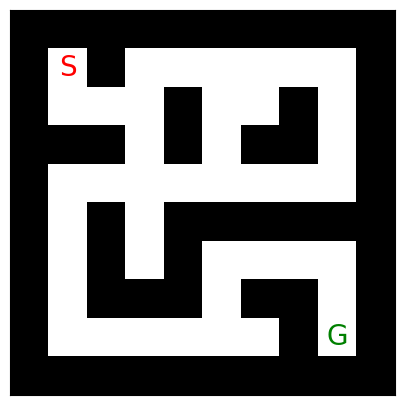

In [4]:
# Create any maze 
maze_layout = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 1, 1, 1, 1, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

# Create an instance of the maze and set the starting and ending positions
maze = Maze(maze_layout, (1, 1), (8, 8))
maze.show_maze()

In [6]:
class QLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.9, 
                 exploration_start=1.0, exploration_end=0.01, num_episodes=100):
        self.maze = maze  # Store maze reference
        self.q_table = {}  # Change to dictionary for sparse representation
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_start = exploration_start
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    def get_exploration_rate(self, current_episode):
        return max(
            self.exploration_end,
            self.exploration_start * (1 - current_episode / self.num_episodes)
        )

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def get_action(self, state, current_episode):
        state = tuple(state)  # Convert state to tuple for dictionary key
        exploration_rate = self.get_exploration_rate(current_episode)
        
        if np.random.rand() < exploration_rate:
            return np.random.randint(4)
        else:
            q_values = [self.get_q_value(state, a) for a in range(4)]
            return np.argmax(q_values)

    def update_q_table(self, state, action, next_state, reward):
        state, next_state = tuple(state), tuple(next_state)
        current_q = self.get_q_value(state, action)
        next_max_q = max(self.get_q_value(next_state, a) for a in range(4))
        
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * next_max_q - current_q
        )
        self.q_table[(state, action)] = new_q

In [7]:
def finish_episode(agent, maze, current_episode, train=True):
    current_state = list(maze.start_position)
    is_done = False
    episode_reward = 0
    episode_steps = 0
    path = [tuple(current_state)]
    max_steps = maze.maze_height * maze.maze_width * 4  # Add step limit
    
    while not is_done and episode_steps < max_steps:
        action = agent.get_action(current_state, current_episode)
        next_state = [
            current_state[0] + actions[action][0],
            current_state[1] + actions[action][1]
        ]
        
        # Check boundaries and walls
        if (next_state[0] < 0 or next_state[0] >= maze.maze_height or
            next_state[1] < 0 or next_state[1] >= maze.maze_width or
            maze.maze[next_state[0]][next_state[1]] == 0):  # Wall is 0 in your maze
            reward = -10  # Wall penalty
            next_state = current_state.copy()
        elif tuple(next_state) == maze.goal_position:
            reward = 100  # Goal reward
            path.append(tuple(next_state))
            is_done = True
        else:
            reward = -1  # Step penalty
            path.append(tuple(next_state))
        
        if train:
            agent.update_q_table(current_state, action, next_state, reward)
        
        current_state = next_state
        episode_reward += reward
        episode_steps += 1
    
    return episode_reward, episode_steps, path

In [8]:
def test_agent(agent, maze, num_episodes=1):
    total_rewards = []
    total_steps = []
    
    for _ in range(num_episodes):
        episode_reward, episode_steps, path = finish_episode(
            agent, maze, num_episodes, train=False
        )
        total_rewards.append(episode_reward)
        total_steps.append(episode_steps)
        
        # Visualize the path
        plt.figure(figsize=(5, 5))
        plt.imshow(maze.maze, cmap='gray')
        plt.text(maze.start_position[1], maze.start_position[0], 'S',
                ha='center', va='center', color='red', fontsize=20)
        plt.text(maze.goal_position[1], maze.goal_position[0], 'G',
                ha='center', va='center', color='green', fontsize=20)
        
        for pos in path:
            plt.text(pos[1], pos[0], '●',
                    ha='center', va='center', color='blue', fontsize=10)
        
        plt.xticks([])
        plt.yticks([])
        plt.grid(True)
        plt.show()
        
    return np.mean(total_steps), np.mean(total_rewards)

In [9]:
def train_agent(agent, maze, num_episodes=100):
    episode_rewards = []
    episode_steps = []
    
    for episode in range(num_episodes):
        episode_reward, episode_step, _ = finish_episode(
            agent, maze, episode, train=True
        )
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)
        
        if (episode + 1) % 10 == 0:  # Progress update every 10 episodes
            print(f"Episode {episode + 1}/{num_episodes}")
    
    # Plot training progress
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards per Episode')
    
    plt.subplot(1, 2, 2)
    plt.plot(episode_steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Steps per Episode')
    
    plt.tight_layout()
    plt.show()
    
    return np.mean(episode_rewards), np.mean(episode_steps)

In [10]:
agent = QLearningAgent(maze)


Training agent...
Episode 10/1000
Episode 20/1000
Episode 30/1000
Episode 40/1000
Episode 50/1000
Episode 60/1000
Episode 70/1000
Episode 80/1000
Episode 90/1000
Episode 100/1000
Episode 110/1000
Episode 120/1000
Episode 130/1000
Episode 140/1000
Episode 150/1000
Episode 160/1000
Episode 170/1000
Episode 180/1000
Episode 190/1000
Episode 200/1000
Episode 210/1000
Episode 220/1000
Episode 230/1000
Episode 240/1000
Episode 250/1000
Episode 260/1000
Episode 270/1000
Episode 280/1000
Episode 290/1000
Episode 300/1000
Episode 310/1000
Episode 320/1000
Episode 330/1000
Episode 340/1000
Episode 350/1000
Episode 360/1000
Episode 370/1000
Episode 380/1000
Episode 390/1000
Episode 400/1000
Episode 410/1000
Episode 420/1000
Episode 430/1000
Episode 440/1000
Episode 450/1000
Episode 460/1000
Episode 470/1000
Episode 480/1000
Episode 490/1000
Episode 500/1000
Episode 510/1000
Episode 520/1000
Episode 530/1000
Episode 540/1000
Episode 550/1000
Episode 560/1000
Episode 570/1000
Episode 580/1000
Episo

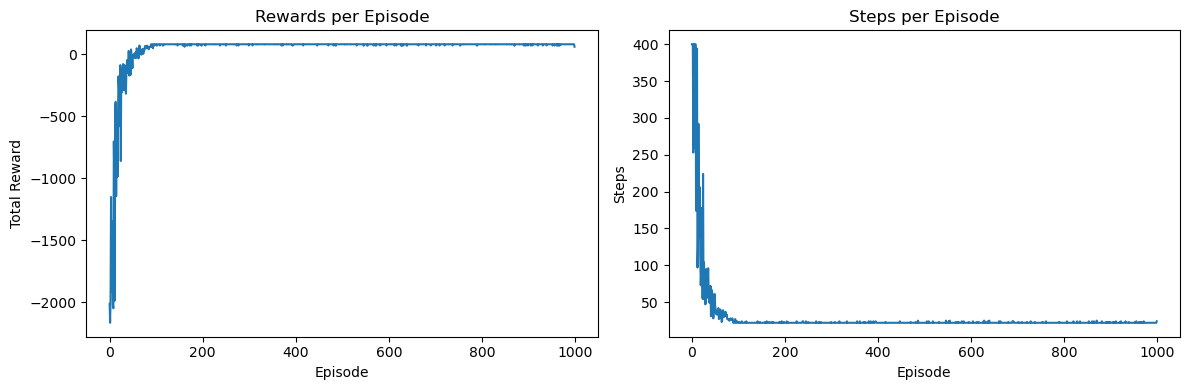

Training completed. Average reward: 41.57, Average steps: 29.00


In [57]:
# Train the agent
print("Training agent...")
avg_reward, avg_steps = train_agent(agent, maze, num_episodes=1000)
print(f"Training completed. Average reward: {avg_reward:.2f}, Average steps: {avg_steps:.2f}")



Testing agent...


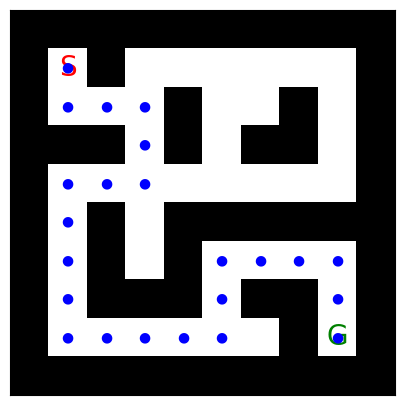

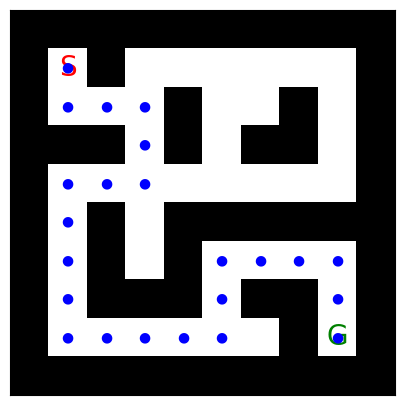

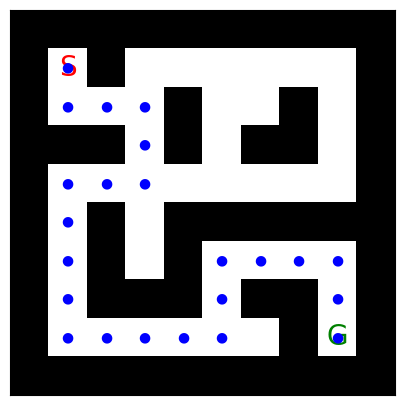

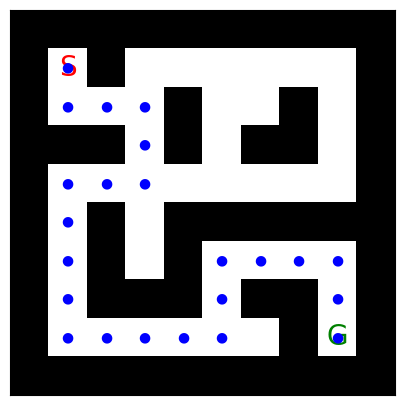

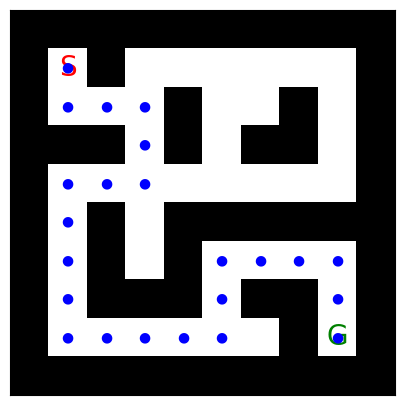

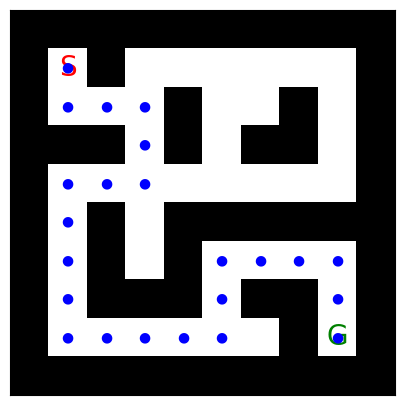

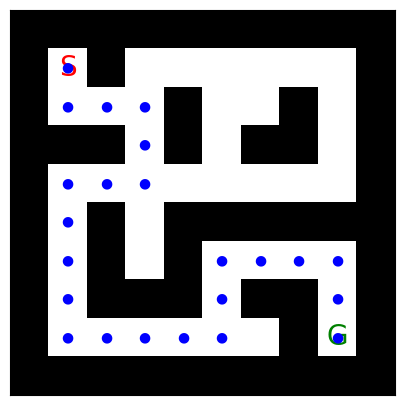

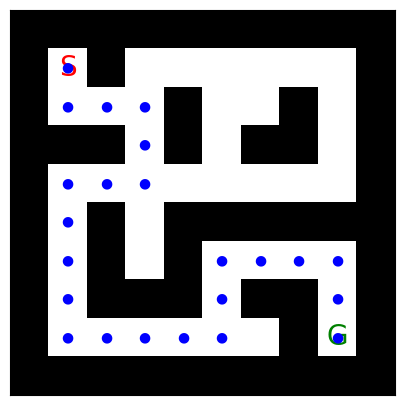

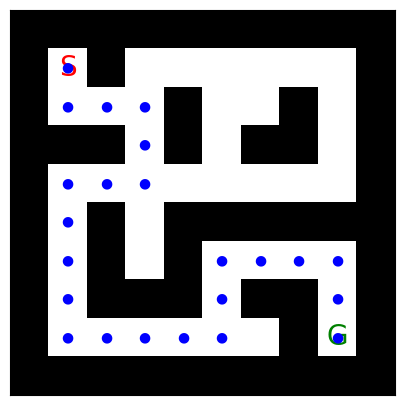

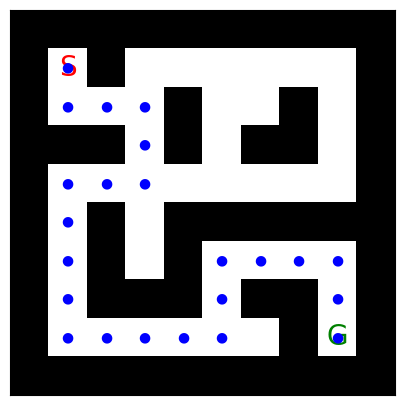

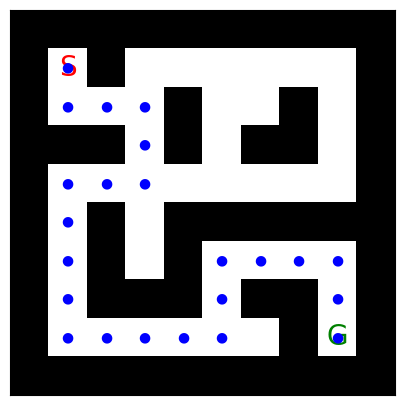

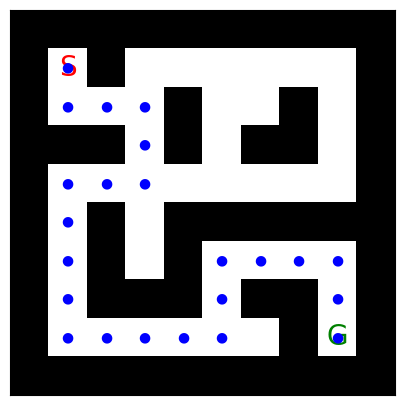

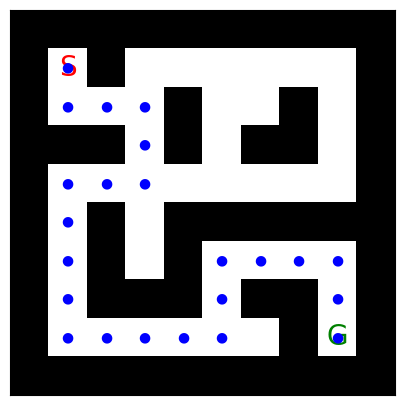

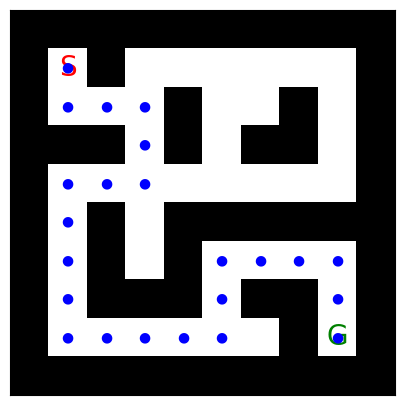

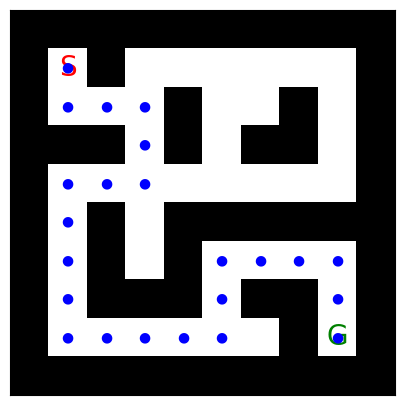

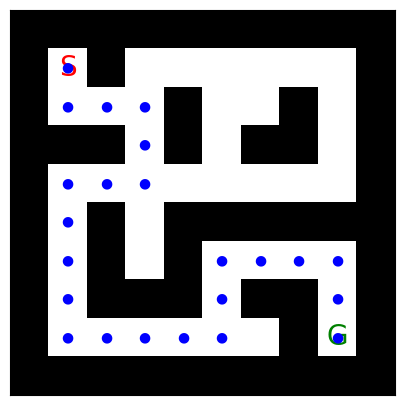

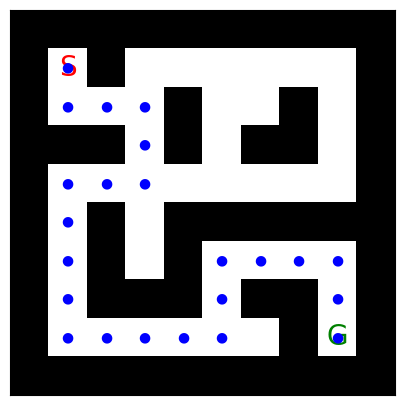

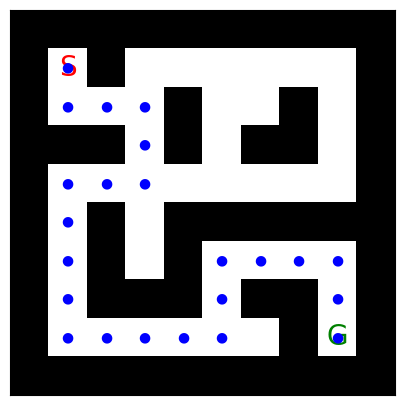

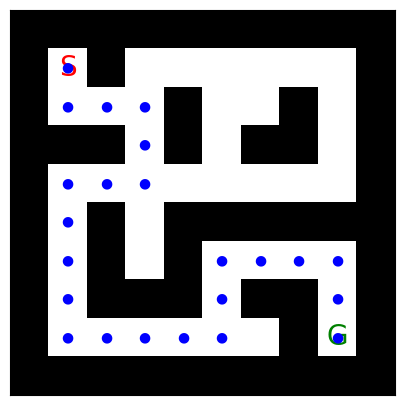

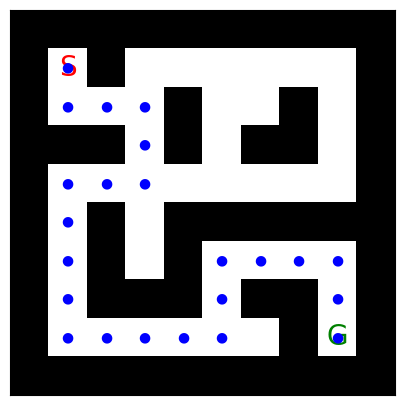

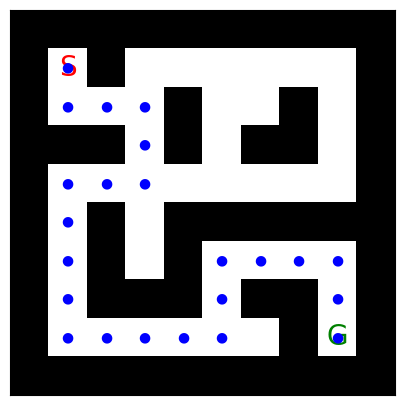

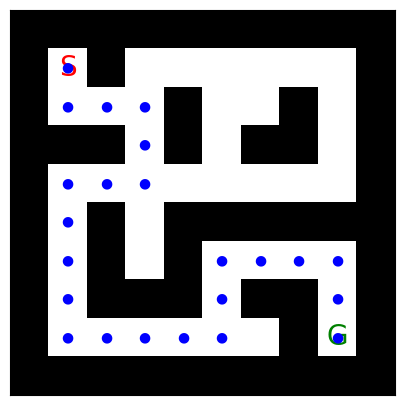

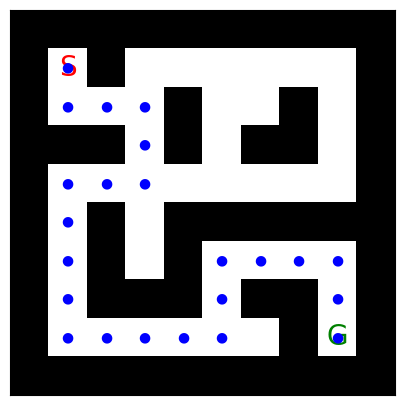

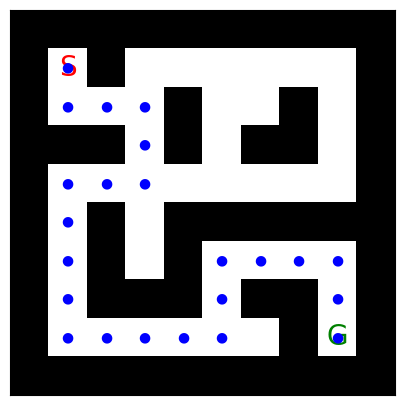

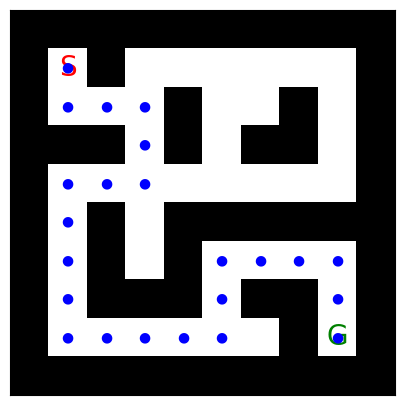

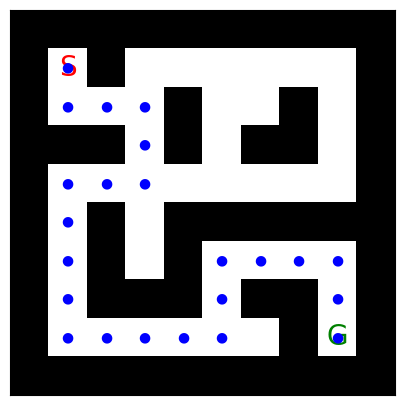

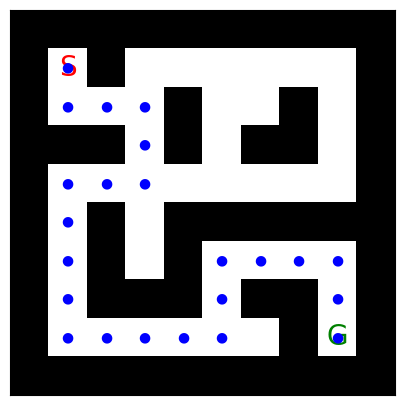

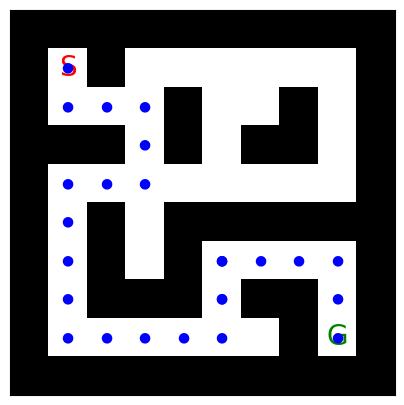

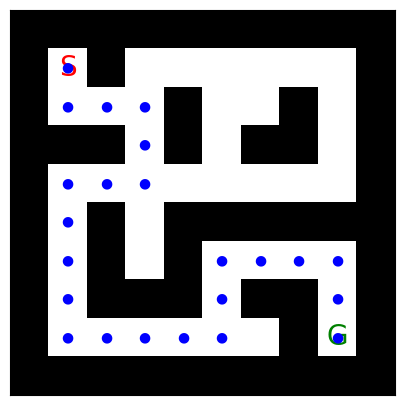

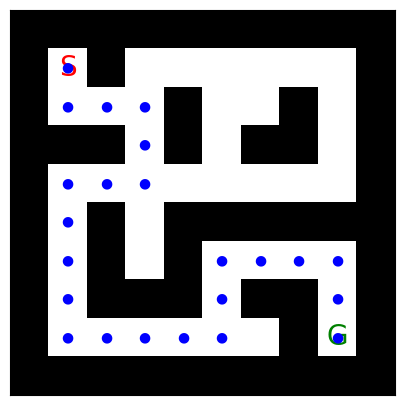

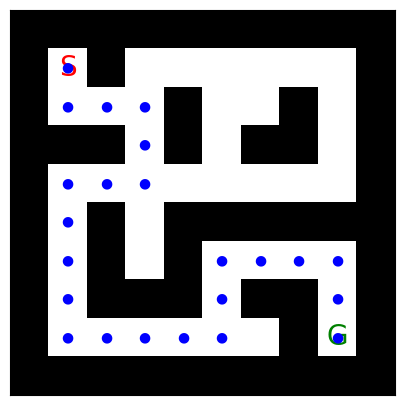

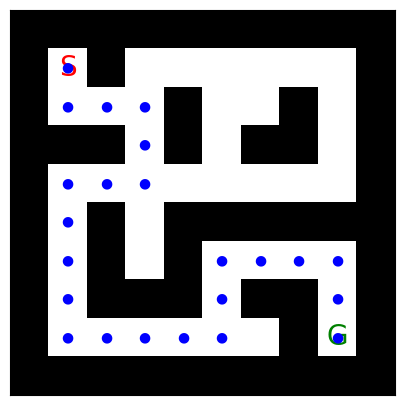

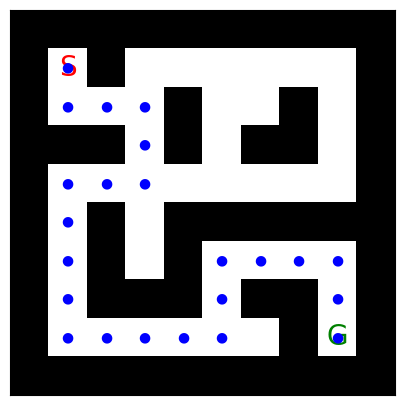

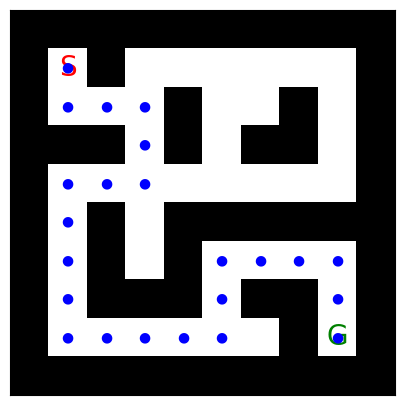

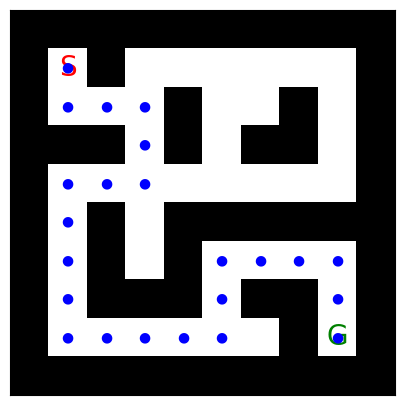

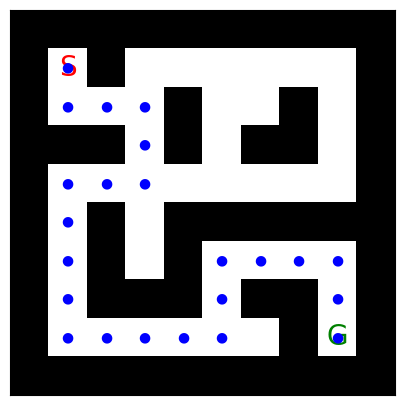

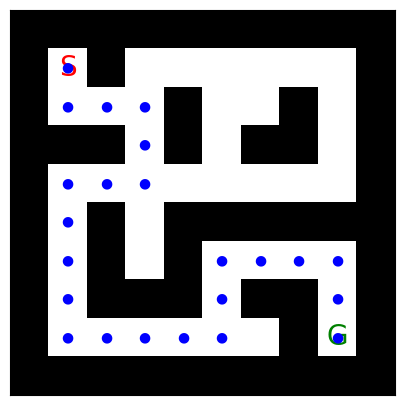

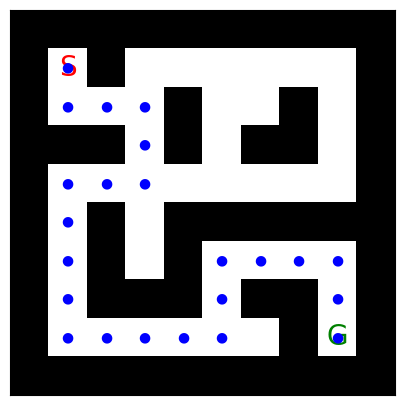

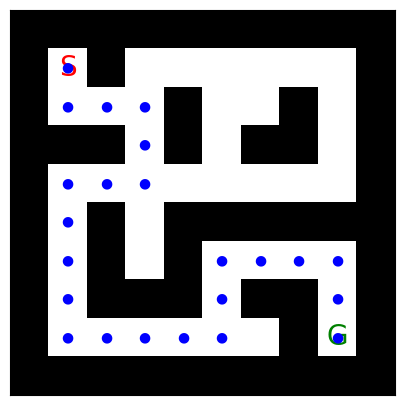

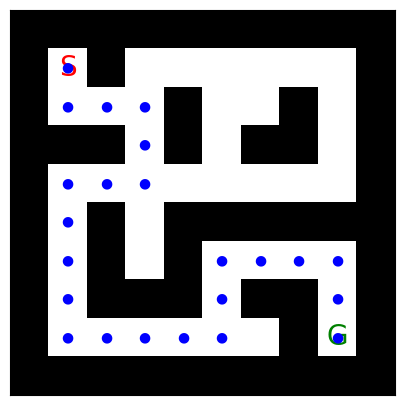

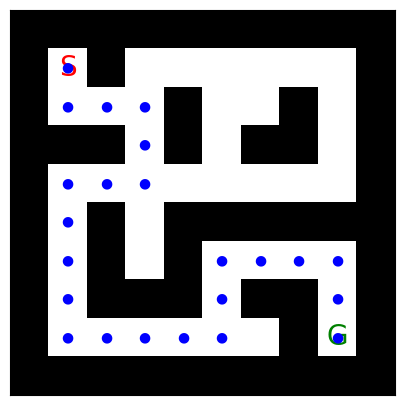

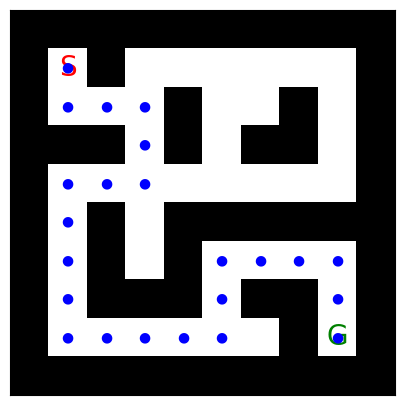

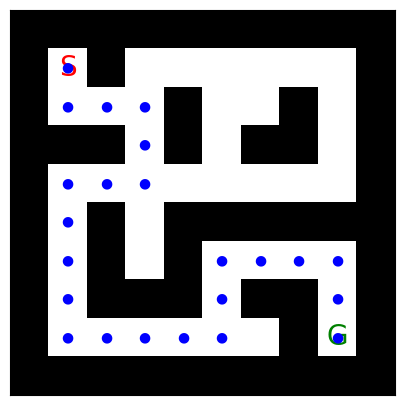

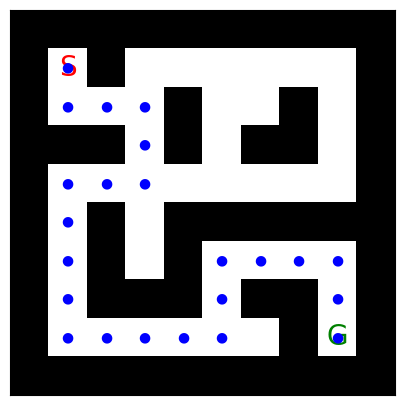

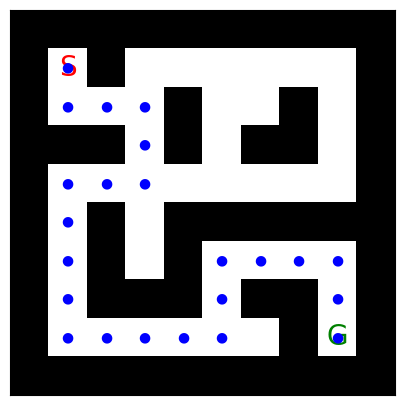

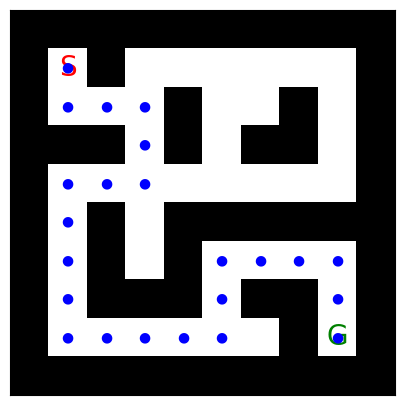

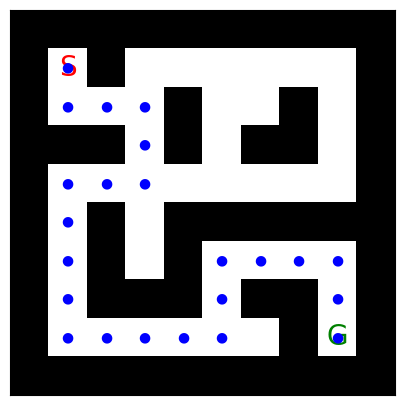

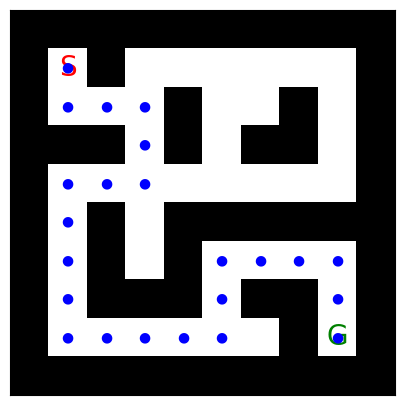

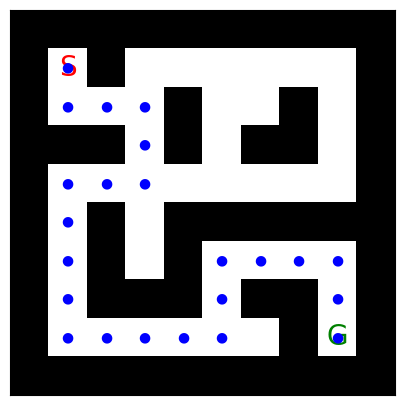

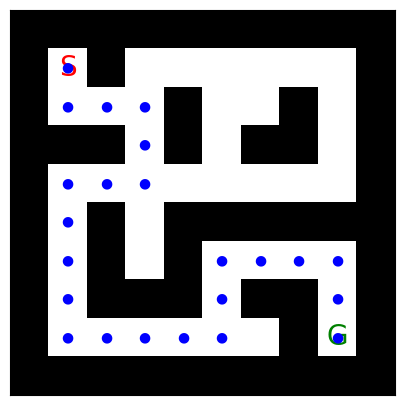

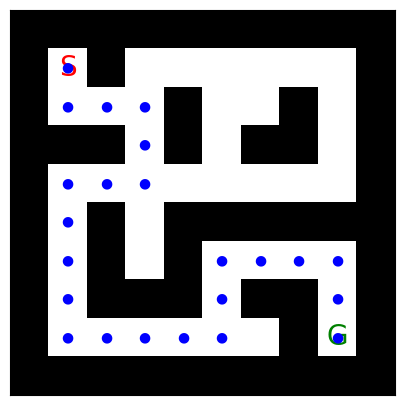

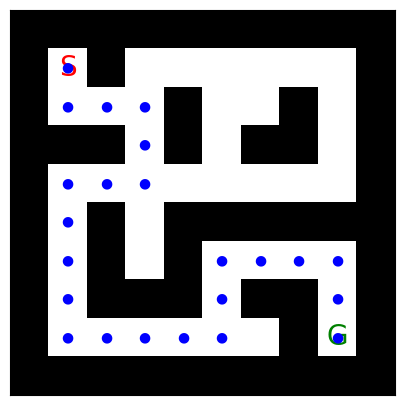

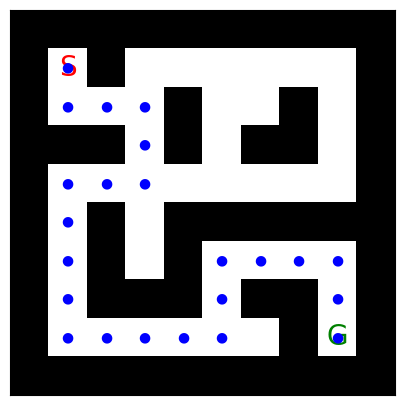

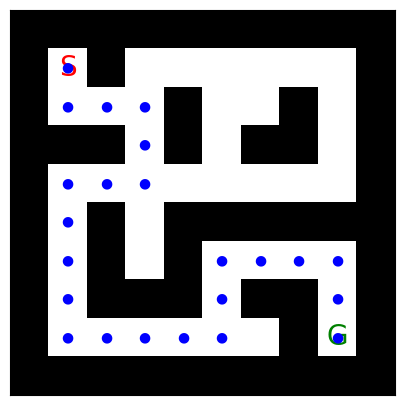

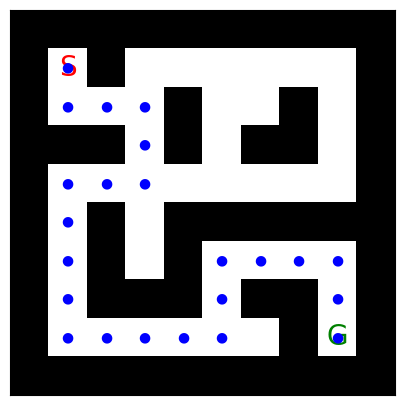

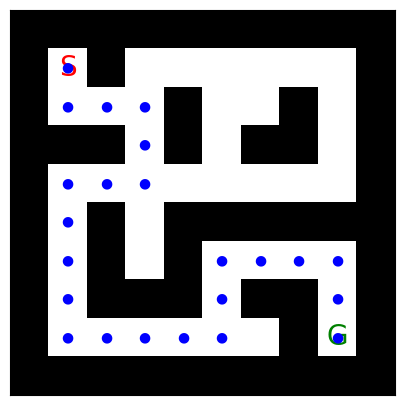

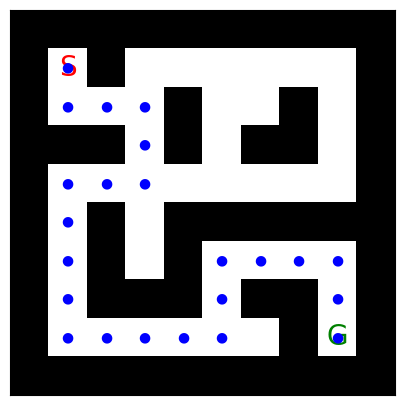

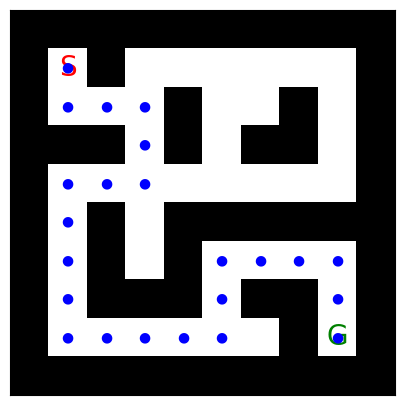

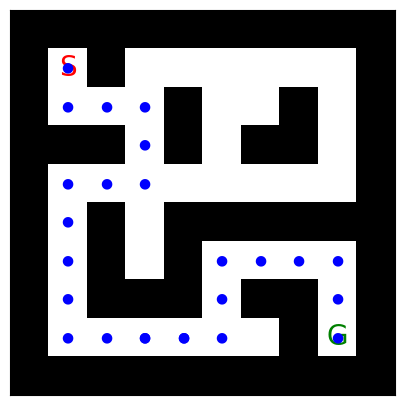

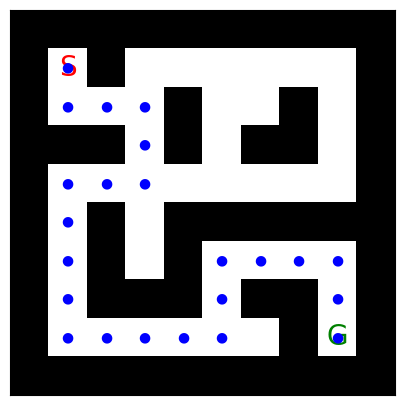

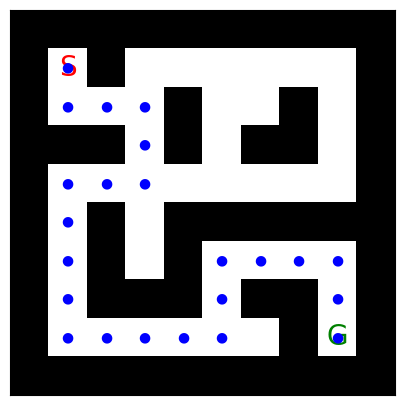

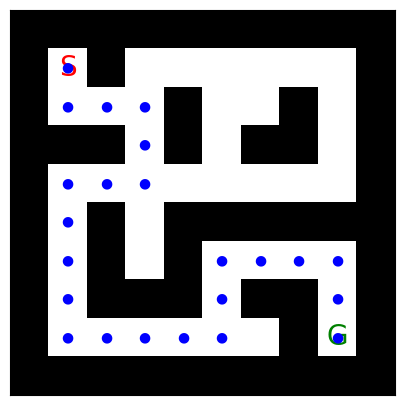

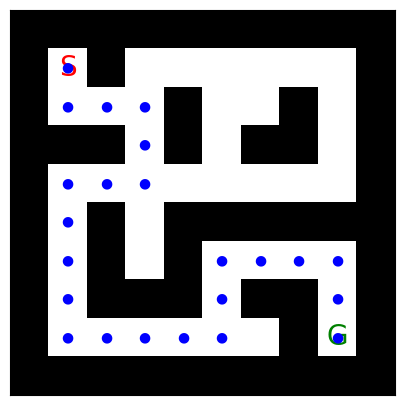

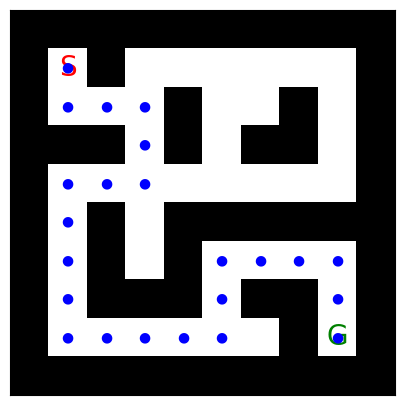

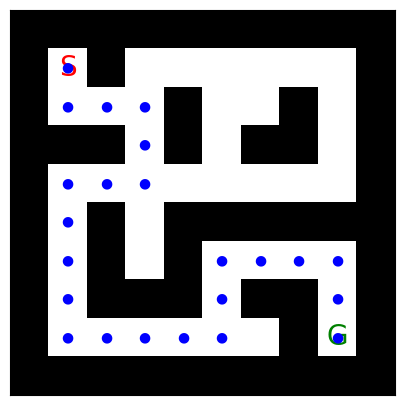

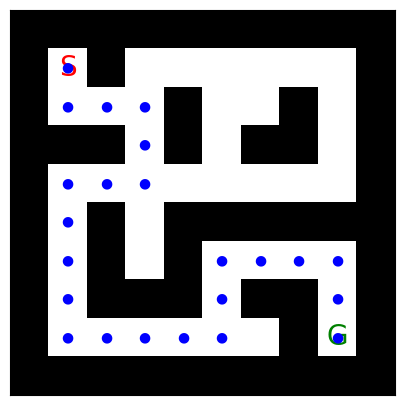

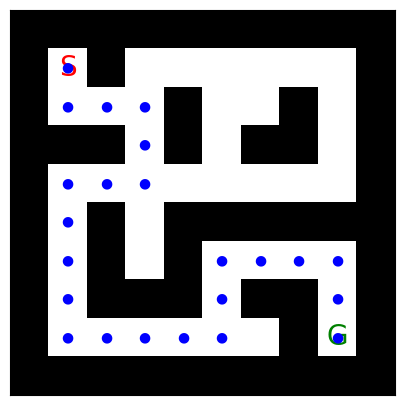

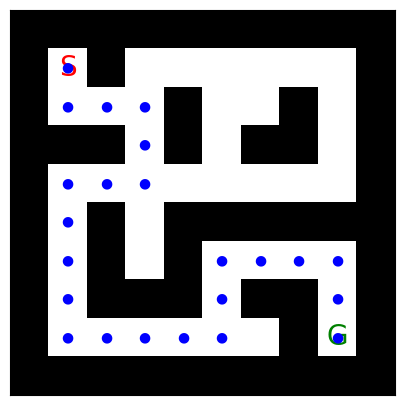

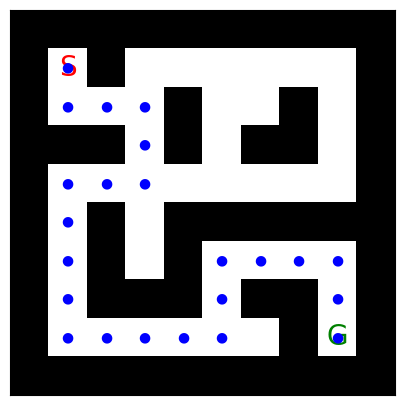

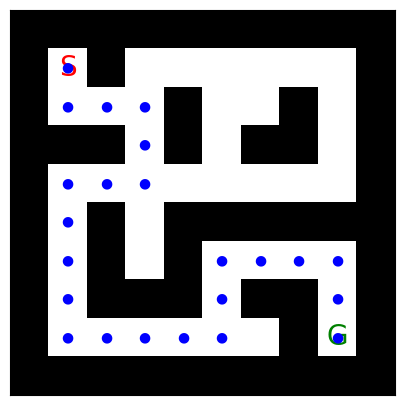

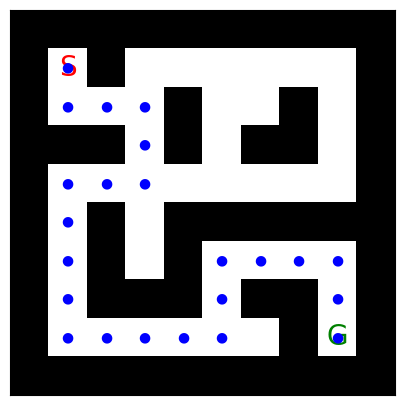

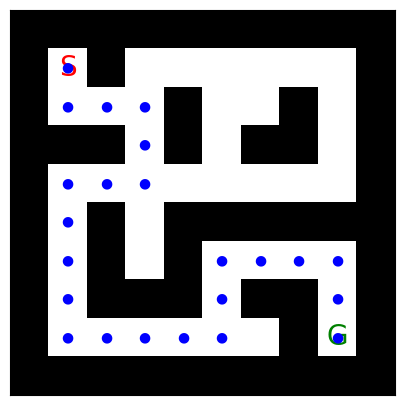

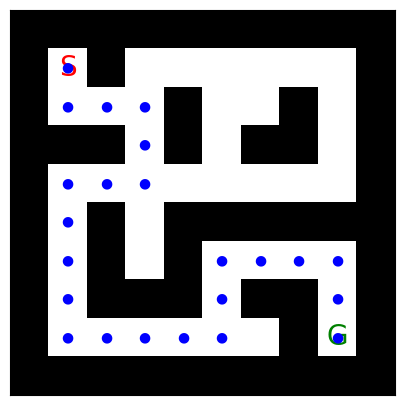

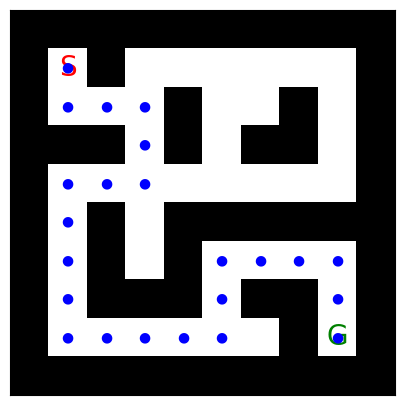

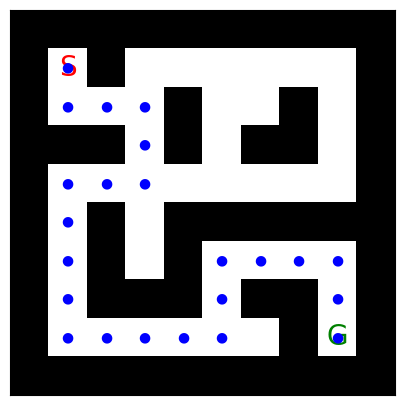

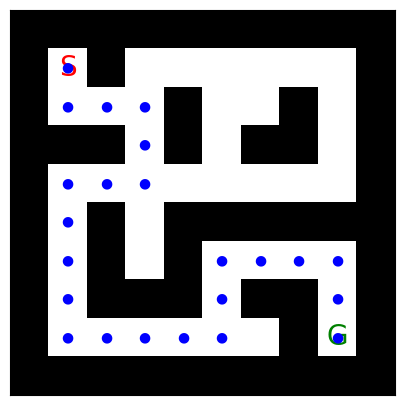

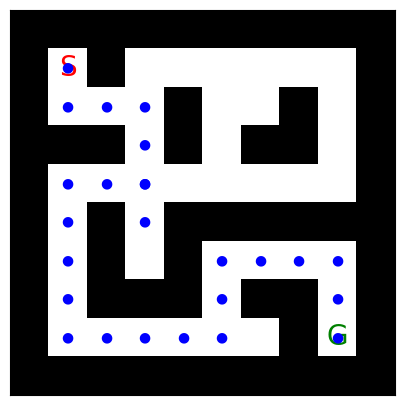

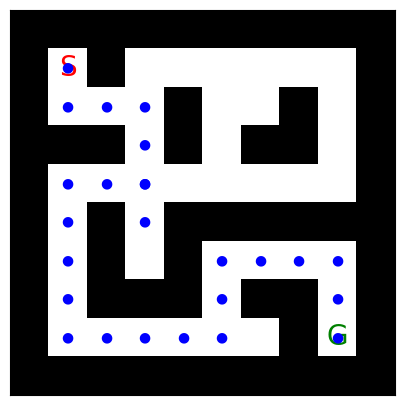

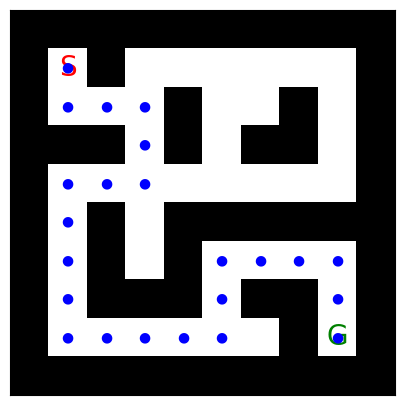

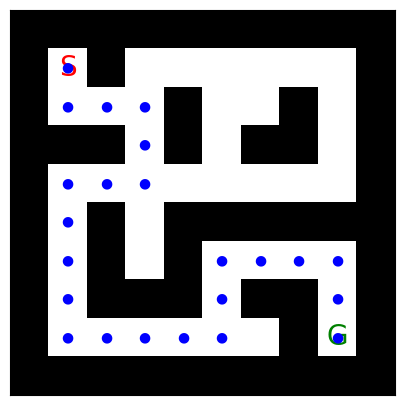

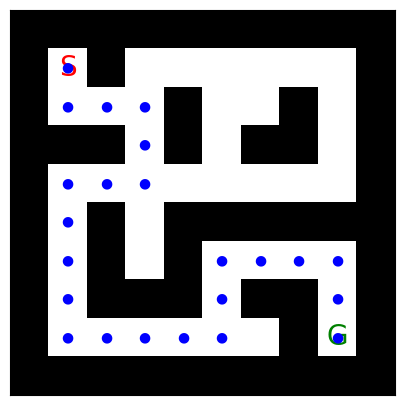

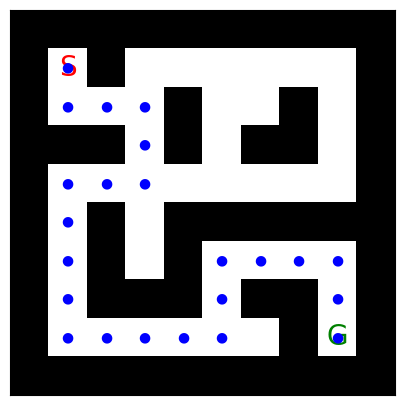

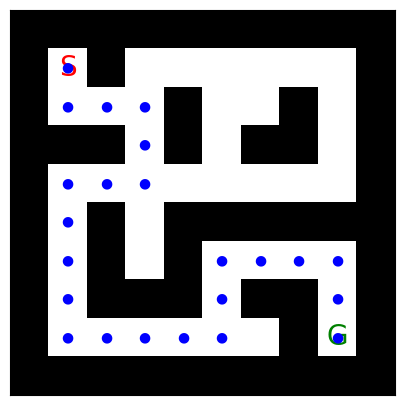

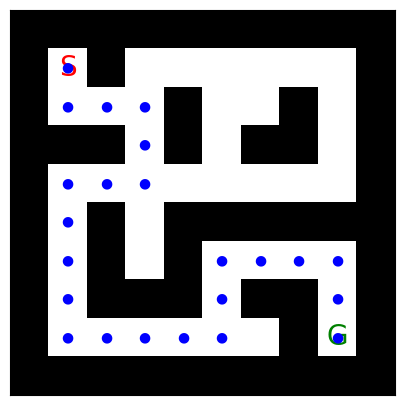

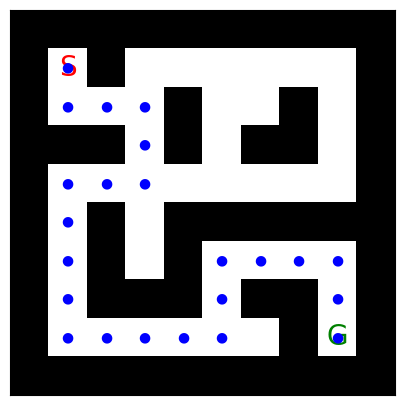

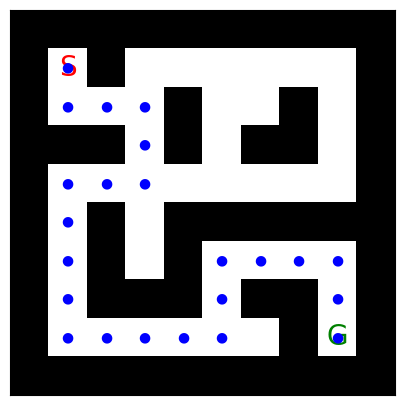

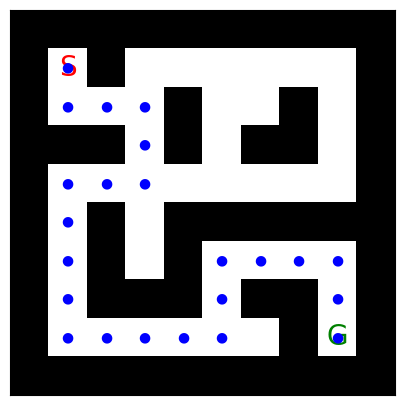

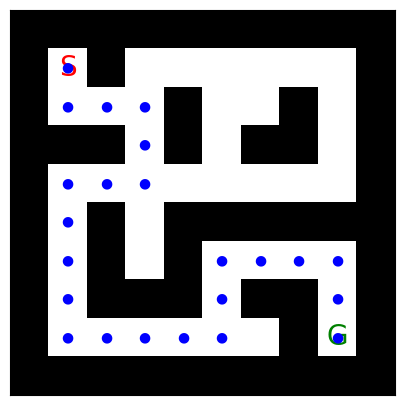

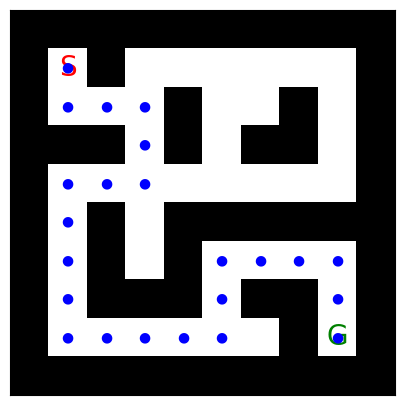

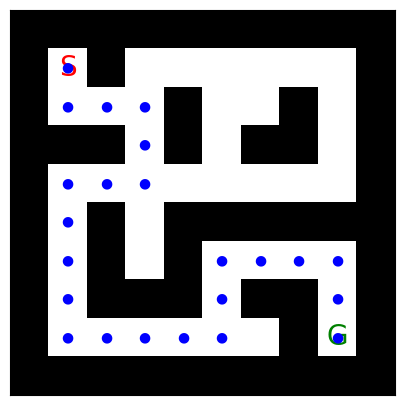

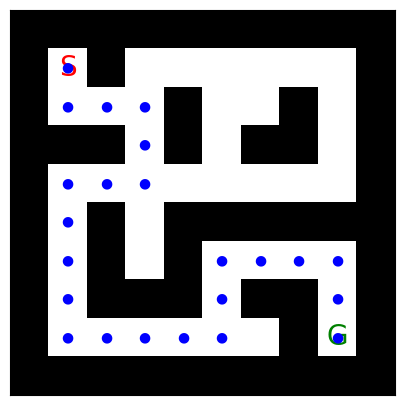

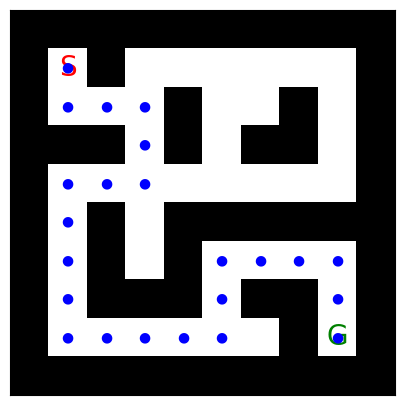

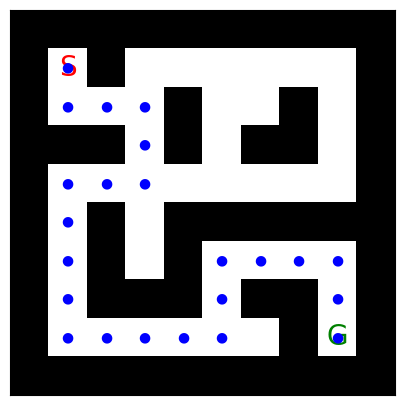

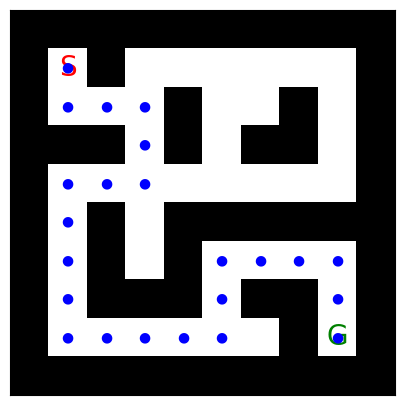

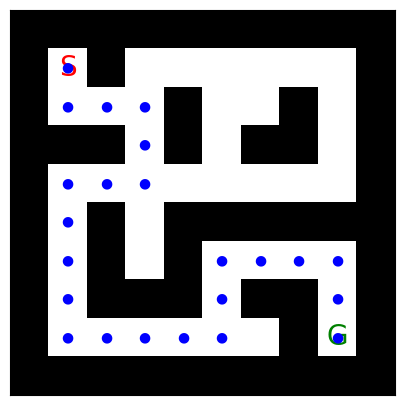

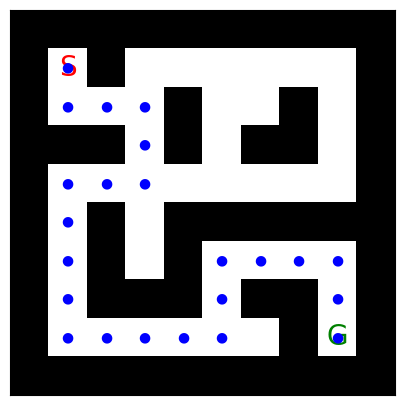

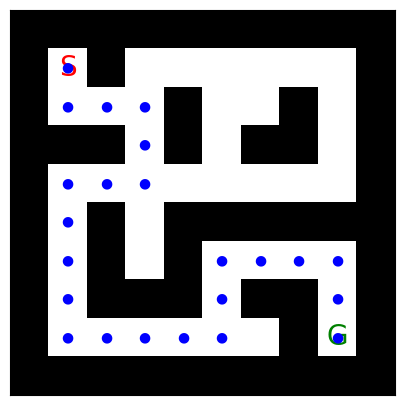

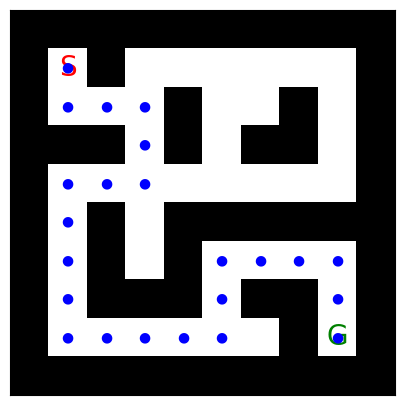

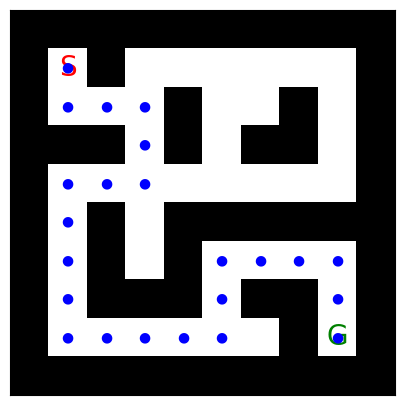

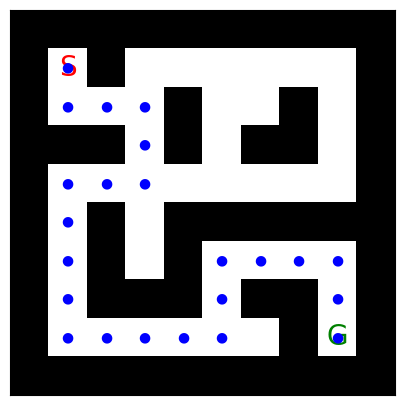

Test completed. Steps: 22.20, Reward: 77.72


In [60]:
# Test the trained agent
print("\nTesting agent...")
test_steps, test_reward = test_agent(agent, maze, num_episodes=100)
print(f"Test completed. Steps: {test_steps:.2f}, Reward: {test_reward:.2f}")